# Data-driven assessment of rest-activity patterns

PSY 394S Machine Learning <br>
Megan McMahon <br>
Fall 2021 <br>

## Using 24 hour data averaged across hourly bins

In [1]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
from matplotlib.dates import WeekdayLocator
import plotly.express as px
import seaborn as sns

from math import ceil
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics, svm, manifold
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

## Load data

In [2]:
actdf = pd.read_csv('/Users/mcmahonmc/Github/machine-learning-2021/final_project/actigraphy_data_24hrday_df.csv')
print('actigraphy df')
print(actdf.shape)

targets = pd.read_csv('/Users/mcmahonmc/Github/machine-learning-2021/final_project/target_data.csv')
targets = targets.set_index('subject')
targets['edge_mean'] = targets[[x for x in targets.columns if x.startswith('edge_')]].mean(axis=1)
print('targets')
print(targets.shape)

targets[:5]

actigraphy df
(24, 125)
targets
(116, 271)


Unnamed: 0  Unnamed: 0.1  age         group  gender  \
subject                                                        
30004             0             0   27  Young Adults       2   
30008             1             1   18  Young Adults       2   
30009             2             2   25  Young Adults       2   
30012             3             3   30  Young Adults       1   
30015             4             4   26  Young Adults       1   

         trails_b_z_score_x trails_b_group  duration_mean_active  \
subject                                                            
30004             -0.673139            Low            937.071429   
30008             -0.869188            Low            872.928571   
30009             -0.834951            Low            981.214286   
30012             -0.268608         Medium            914.857143   
30015             -1.563107            Low            899.857143   

         duration_mean_daily  duration_mean_rest  ...  pc_dmn_fpn_20  \
subject                                           ...                  
30004            1263.428571          436.428571  ...       0.218853   
30008            1251.214286          501.857143  ...       0.218107   
30009            1317.000000          455.142857  ...       0.222053   
30012            1288.571429          465.000000  ...            NaN   
30015            1438.714286          452.000000  ...       0.277564   

         pc_dmn_fpn_mean  pc_dmn_mean  pc_fpn_mean    edge_0    edge_1  \
subject                                                                  
30004           0.178769     0.585333     0.755358  0.451471  0.509899   
30008           0.194311     0.586016     0.720762  0.425655  0.824386   
30009           0.192073     0.482981     0.814453  0.508419  0.634550   
30012                NaN          NaN          NaN       NaN       NaN   
30015           0.237269     0.651844     0.738657  0.264530  0.418911   

           edge_2    edge_3  acc_mean_test_log  edge_mean  
subject                                                    
30004    0.257227  0.688757          -0.028171   0.476839  
30008    1.032888  0.311497          -0.057158   0.648607  
30009    0.578941  0.278736          -0.028171   0.500161  
30012         NaN       NaN          -0.216223        NaN  
30015    0.402329  0.096133          -0.117783   0.295476  

[5 rows x 271 columns]

In [3]:
actdf.T

0          1          2          3          4           5   \
30004  44.075919   9.698810  20.614286   2.113095   1.577381   10.184524   
30008  65.311981  55.135714  27.895238   3.260714   3.807143    4.428571   
30009  42.480427   3.757143   6.657143  13.963095   7.488095   36.059524   
30012  22.226572  18.959524   8.765476  14.610714   8.289286    4.510714   
30015   2.408066   3.847619   4.711905   4.471429   8.021429   56.523810   
...          ...        ...        ...        ...        ...         ...   
40859  18.863582  27.140476  23.959524  52.880952  30.026190   25.813095   
40861  11.865955  51.561905  28.398810  46.077381  68.986905  112.108333   
40876  61.785291  29.872619  31.467857  15.986905   9.826190   13.771429   
40878  68.079478  15.238095  14.428571  11.051190  14.453571   40.751190   
40891  52.779359  70.721429  73.030952  52.816667  44.627381   40.572619   

               6           7           8           9   ...          14  \
30004   69.186905  145.825000  137.346429  180.741667  ...  113.966667   
30008   12.227381   51.623810  142.414286  163.984524  ...   99.741667   
30009  149.613095  176.075000  159.464286  191.546429  ...  195.822619   
30012   24.671429   94.663095  192.967857  168.408333  ...  276.166667   
30015  175.069048  110.132143  142.128571  101.926190  ...   81.286905   
...           ...         ...         ...         ...  ...         ...   
40859  129.875000  158.746429  248.402381  212.880952  ...  213.959524   
40861   82.555952  214.008333   91.454762  151.055952  ...   66.738095   
40876   17.313095   63.477381  144.602381   80.810714  ...  129.550000   
40878  109.552381  123.623810  158.142857  115.057143  ...  168.989286   
40891   48.321429   58.730952  118.576190   79.582143  ...   21.300000   

               15          16          17          18          19          20  \
30004  154.771429  147.825000  200.713095  194.197619  196.728571  162.066667   
30008  108.609524   97.469048  165.205952  139.730952  162.625000  178.694048   
30009  166.578571  353.890476  384.421429  415.090476  216.370238  318.708333   
30012  278.854762  205.377381  211.129762  256.602381  248.715476  225.535714   
30015  104.388095  193.416667  146.789286  106.690476  327.391667  412.196429   
...           ...         ...         ...         ...         ...         ...   
40859  171.934524  127.972619  144.423810  170.757143  102.498810   67.019048   
40861   90.760714   96.775000   89.707143  126.129762   79.007143   51.726190   
40876  131.404762  159.873810  160.882143  146.548810  180.776190  190.303571   
40878  181.744048  191.985714  164.397619  166.955952  130.289286  152.416667   
40891   34.876190   58.644048   44.291667   47.586905   32.304762   69.742857   

               21          22         23  
30004  117.598810  111.240476  54.716667  
30008  124.877381  135.992857  99.036905  
30009  165.997619  129.489286  58.301190  
30012  238.240476  101.419048  48.121429  
30015  109.877381   53.571429  27.045238  
...           ...         ...        ...  
40859   72.534524   46.160714   5.071429  
40861   18.446429   40.575000  24.430952  
40876  180.066667   99.828571  79.820238  
40878  100.594048   95.965476  30.032143  
40891   81.663095   99.207143  64.946429  

[125 rows x 24 columns]

In [4]:
x = StandardScaler().fit_transform(actdf.T.values) # normalizing the features

<AxesSubplot:>

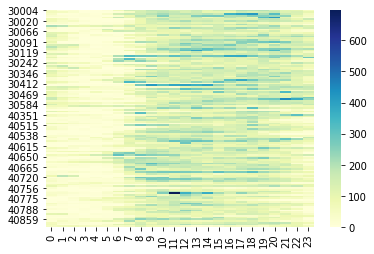

In [5]:
sns.heatmap(actdf.T, cmap="YlGnBu")

<AxesSubplot:>

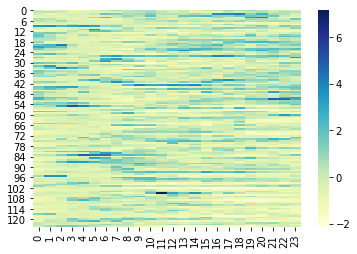

In [6]:
sns.heatmap(x, cmap="YlGnBu")

<AxesSubplot:>

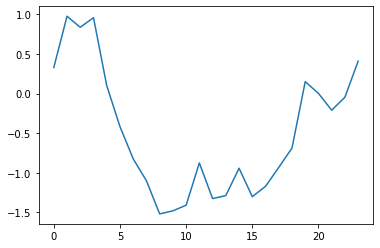

In [7]:
sns.lineplot(x=range(0,len(x[100])), y=x[100])

In [8]:
drop_subs = [ subject for subject in actdf.columns if int(subject) not in targets.index.values ]
drop_subs_idx = [ actdf.columns.get_loc(subject) for subject in actdf.columns if int(subject) not in targets.index.values ]

actdf = actdf.drop(drop_subs, axis=1)[:-3]
x = np.delete(x, drop_subs_idx, axis=0)

print(actdf.shape)
print(x.shape)

(21, 116)
(116, 24)


In [9]:
# from sklearn.preprocessing import StandardScaler
# x = actdf.values
# x = StandardScaler().fit_transform(x) # normalizing the features
# x.shape

In [10]:
x

array([[-0.16930274, -0.69603181, -0.19727396, ..., -0.01027281,
         0.20237303, -0.37903847],
       [ 0.28471045,  0.4005727 ,  0.02591371, ...,  0.09637948,
         0.60471463,  0.37252659],
       [-0.20341333, -0.83943195, -0.62511114, ...,  0.69891082,
         0.49900127, -0.31825353],
       ...,
       [-0.85793084,  0.31432   ,  0.04135   , ..., -1.46314419,
        -0.94627046, -0.89261162],
       [ 0.2093121 , -0.20914366,  0.13542747, ...,  0.90506338,
         0.01687636,  0.04665796],
       [ 0.34387774, -0.562343  , -0.38688859, ..., -0.25944214,
        -0.04591695, -0.79762885]])

In [11]:
np.mean(x),np.std(x)

(0.03239384295367066, 0.9990678345114128)

## Compute traditional rest-activity measures


In [12]:
# from wearables import fitcosinor, npmetrics
# from datetime import datetime

# rar = pd.DataFrame()

# for subject in actdf.columns:
    
#     df = pd.DataFrame(actdf[subject][:-2]).set_index(pd.to_datetime(
#         pd.date_range(start = pd.to_datetime('2021-01-01 00:00:00'),
#                       end = pd.to_datetime('2021-01-01 00:00:00') + pd.Timedelta(days=7),
#                       freq='30S'),
#         format = '%Y-%m-%d %H:%M:%S'))
    
#     df.columns = ['Activity']
    
#     cr = np.array(fitcosinor.fitcosinor(df)[0].T.values).T[0]
#     nonp = npmetrics.np_metrics_all(df['Activity'])
    
#     rar[subject] = np.concatenate((cr, nonp[:3]))
    
# rar = rar.T
# rar.columns = ['actmin', 'amp', 'alpha', 'beta', 'phi', 'IS', 'IV', 'RA']
# rar

In [13]:
rar = pd.read_csv('/Users/mcmahonmc/Github/machine-learning-2021/final_project/rar_df.csv', index_col=0)

drop_subs = [ int(subject) for subject in rar.index if str(subject) not in actdf.columns.values ]
drop_subs

rar2 = (rar[~rar.index.isin(drop_subs)])
print(rar2.shape)

(116, 8)


In [14]:
[col for col in targets.columns if 'mean_active' in col]

['duration_mean_active', 'total_ac_mean_active', 'sleep_time_mean_active']

In [15]:
[col for col in targets.columns if 'mean_sleep' in col]

['duration_mean_sleep',
 'total_ac_mean_sleep',
 'onset_latency_mean_sleep',
 'efficiency_mean_sleep',
 'sleep_time_mean_sleep']

<AxesSubplot:>

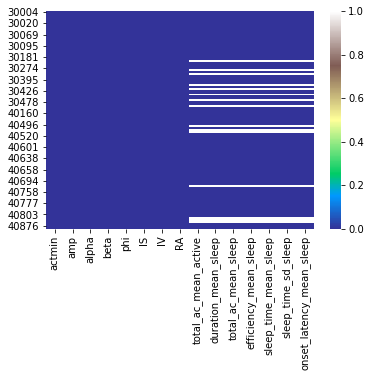

In [16]:
rar2 = rar2.merge(targets[['total_ac_mean_active',
                    'duration_mean_sleep', 
                    'total_ac_mean_sleep', 
                   'efficiency_mean_sleep',
                   'sleep_time_mean_sleep',
                   'sleep_time_sd_sleep',
                   'onset_latency_mean_sleep']],
          left_index=True, right_index=True)

sns.heatmap(rar2.isnull(), cmap='terrain')

In [17]:
# rar.to_csv('/Users/mcmahonmc/Github/machine-learning-2021/final_project/rar_df.csv')

### Define targets

target data uses output from rar dataframe merged with other variables of interest

**Missing data**

Missing data here for CESD (this is intended for young adults only), GDS (this is intended for older adults only), and some of the MRI measures (due to poor image quality).

For targets of interest, will impute missing values with the mean.

<AxesSubplot:ylabel='subject'>

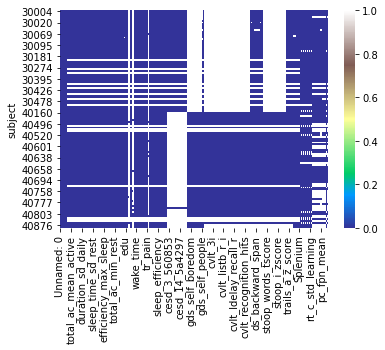

In [18]:
sns.heatmap(targets.isnull(), cmap='terrain')

In [19]:
# targets.to_csv('/Users/mcmahonmc/Github/machine-learning-2021/final/target_data.csv', index=True)

# Dimensionality Reduction

## PCA

[7.193233   5.07819033 3.47252117 2.02986676 0.98347869 0.83362553
 0.67407316 0.52493029]


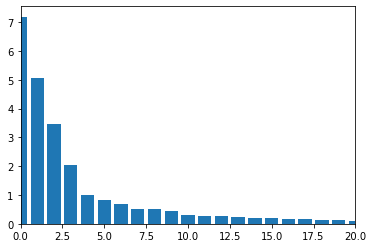

In [20]:
pca = PCA()
data_pcs = pca.fit_transform(x)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlim(0,20)
print(pca.explained_variance_[:8])

In [21]:
components_n = 3

In [22]:
pca = PCA(n_components=components_n)

# X: Xarray-like of shape (n_samples, n_features)
pca.fit(x)
manifold_2Da_pca = pca.fit_transform(x)
manifold_2D_pca = pd.DataFrame(manifold_2Da_pca, 
                               columns=['Component %s' % (i+1) for i in range(0, len(manifold_2Da_pca[0]))])

# Left with 2 dimensions
print(manifold_2D_pca.shape)
manifold_2D_pca.head()

(116, 3)


Component 1  Component 2  Component 3
0     0.894115    -0.960294    -0.567821
1     0.067035     0.515463    -0.986162
2     5.740931    -1.323334     0.657220
3     4.521819    -0.873743    -0.747145
4     0.928195    -1.038062     0.193272

In [23]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.29794784 0.21034156 0.14383382]


## Isomap

[Benalexkeen resource](https://benalexkeen.com/isomap-for-dimensionality-reduction-in-python/)

In [24]:
iso = manifold.Isomap(n_neighbors=6, n_components=components_n)
iso.fit(x)
manifold_2Da = iso.transform(x)
manifold_2D_iso = pd.DataFrame(manifold_2Da, 
                               columns=['Component %s' % (i+1) for i in range(0, len(manifold_2Da[0]))])


# Left with 2 dimensions
print(manifold_2D_iso.shape)
manifold_2D_iso.head()

(116, 3)


Component 1  Component 2  Component 3
0    -0.863064     1.808817     0.659990
1    -2.970737    -1.082638     0.155360
2    -7.436831     7.585445     1.782616
3    -5.313697     4.959119    -1.928095
4     0.584510     0.357600     1.551646

## LLE

In [25]:
lle = manifold.LocallyLinearEmbedding(n_neighbors=6, n_components=components_n)
lle.fit(x)
manifold_2Da_lle = lle.transform(x)
manifold_2D_lle = pd.DataFrame(manifold_2Da, 
                               columns=['Component %s' % (i+1) for i in range(0, len(manifold_2Da[0]))])



# Left with 2 dimensions
print(manifold_2D_lle.shape)
manifold_2D_lle.head()

(116, 3)


Component 1  Component 2  Component 3
0    -0.863064     1.808817     0.659990
1    -2.970737    -1.082638     0.155360
2    -7.436831     7.585445     1.782616
3    -5.313697     4.959119    -1.928095
4     0.584510     0.357600     1.551646

# Comparison with traditional sleep and rest-activity measures

## PCA

Component 1 - total activity <br>
Component 2 - acrophase (phi)

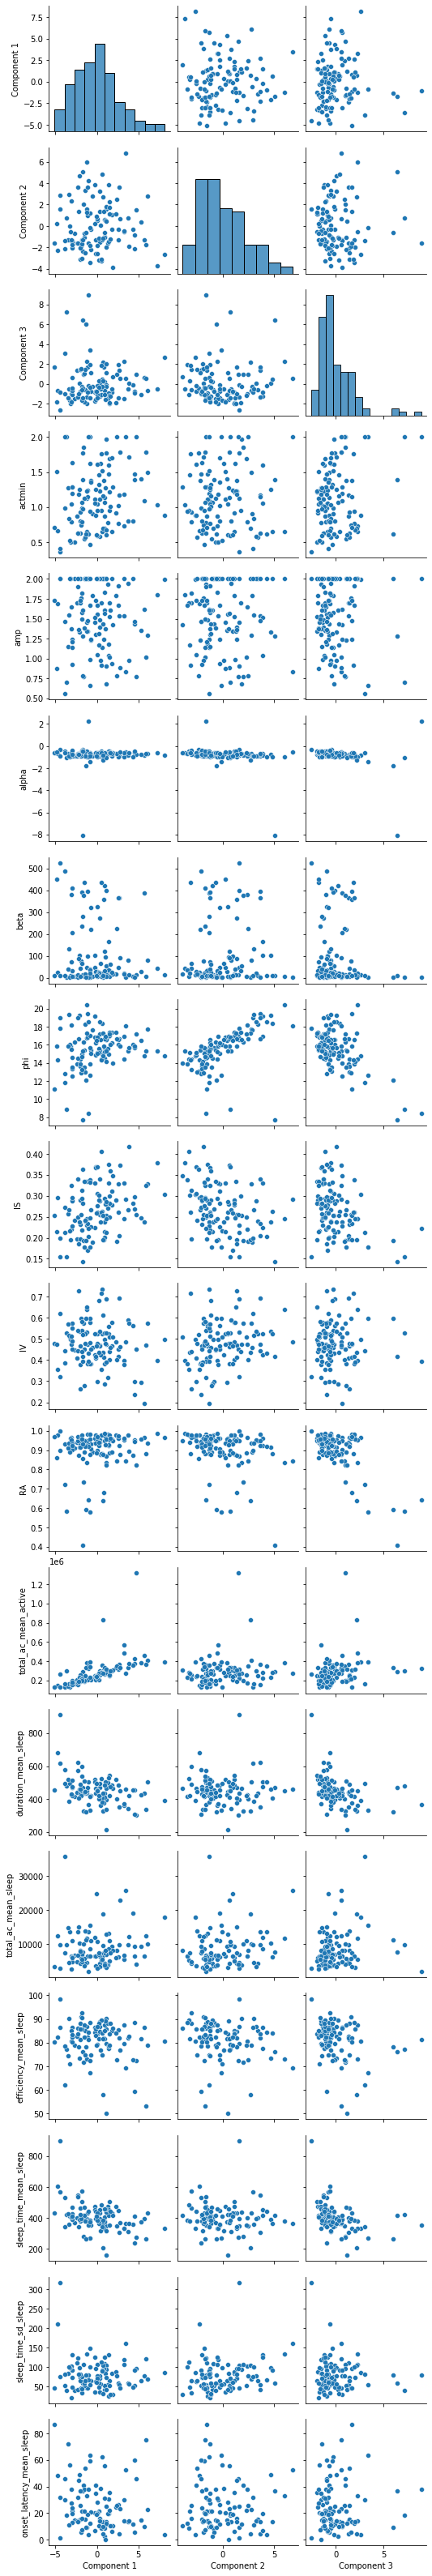

In [26]:
sns.pairplot(data=manifold_2D_pca.join(rar2.reset_index().drop('index', axis=1)), 
             x_vars = [col for col in manifold_2D_pca.columns if col.startswith('Component')])

<AxesSubplot:>

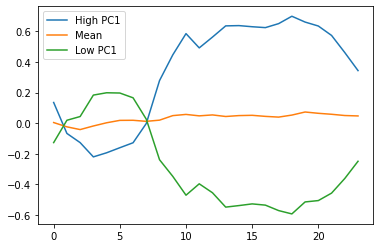

In [27]:
comp1_high_idx, comp1_low_idx = [np.where(manifold_2D_pca['Component 1'] > manifold_2D_pca['Component 1'].median()),
                 np.where(manifold_2D_pca['Component 1'] < manifold_2D_pca['Component 1'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp1_high_idx].mean(axis=0), label='High PC1')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp1_low_idx].mean(axis=0), label='Low PC1')

<AxesSubplot:>

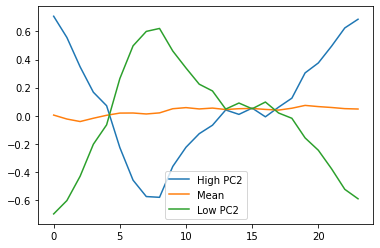

In [28]:
comp2_high_idx, comp2_low_idx = [np.where(manifold_2D_pca['Component 2'] > manifold_2D_pca['Component 2'].median()),
                 np.where(manifold_2D_pca['Component 2'] < manifold_2D_pca['Component 2'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp2_high_idx].mean(axis=0), label='High PC2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp2_low_idx].mean(axis=0), label='Low PC2')

<AxesSubplot:>

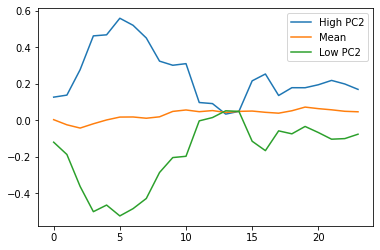

In [29]:
comp3_high_idx, comp3_low_idx = [np.where(manifold_2D_pca['Component 3'] > manifold_2D_pca['Component 3'].median()),
                 np.where(manifold_2D_pca['Component 3'] < manifold_2D_pca['Component 3'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp3_high_idx].mean(axis=0), label='High PC2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp3_low_idx].mean(axis=0), label='Low PC2')

## Isomap

Isomap uses the above principle to create a similarity matrix for eigenvalue decomposition. Unlike other non-linear dimensionality reduction like LLE & LPP which only use local information, isomap uses the local information to create a global similarity matrix. The isomap algorithm uses euclidean metrics to prepare the neighborhood graph. Then, it approximates the geodesic distance between two points by measuring shortest path between these points using graph distance. Thus, it approximates both global as well as the local structure of the dataset in the low dimensional embedding. -[Paperspace Blog](https://blog.paperspace.com/dimension-reduction-with-isomap/)

Component 2 - phi

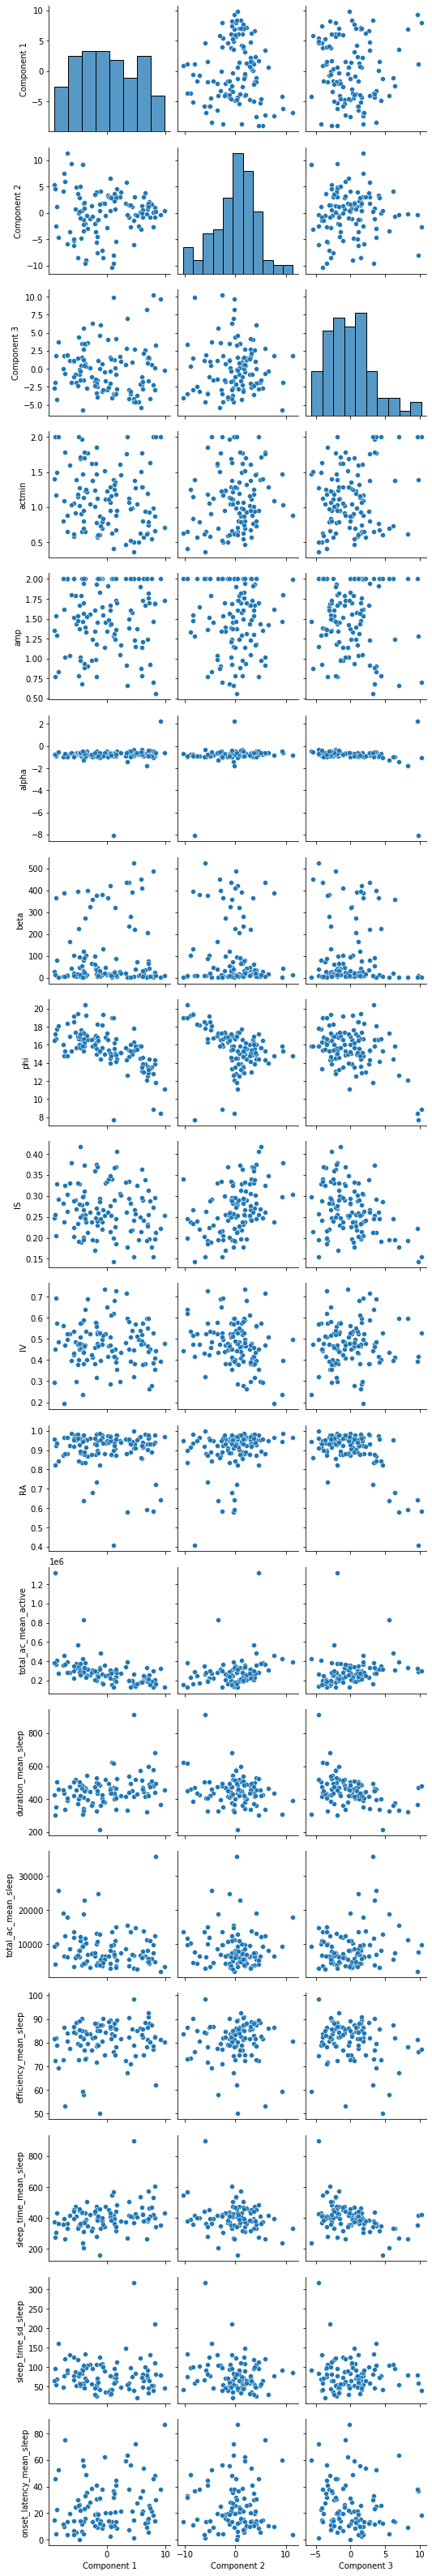

In [30]:
sns.pairplot(data=manifold_2D_iso.join(rar2.reset_index().drop('index', axis=1)), 
             x_vars = [col for col in manifold_2D_iso.columns if col.startswith('Component')])

<AxesSubplot:>

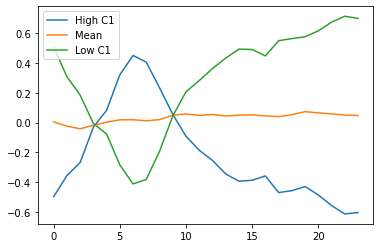

In [31]:
comp1_high_idx, comp1_low_idx = [np.where(manifold_2D_iso['Component 1'] > manifold_2D_iso['Component 1'].median()),
                 np.where(manifold_2D_iso['Component 1'] < manifold_2D_iso['Component 1'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp1_high_idx].mean(axis=0), label='High C1')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp1_low_idx].mean(axis=0), label='Low C1')

<AxesSubplot:>

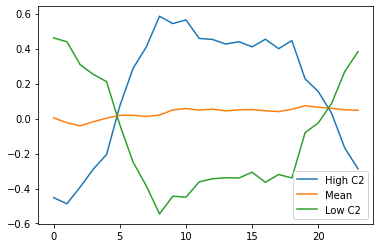

In [32]:
comp2_high_idx, comp2_low_idx = [np.where(manifold_2D_iso['Component 2'] > manifold_2D_iso['Component 2'].median()),
                 np.where(manifold_2D_iso['Component 2'] < manifold_2D_iso['Component 2'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp2_high_idx].mean(axis=0), label='High C2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp2_low_idx].mean(axis=0), label='Low C2')

<AxesSubplot:>

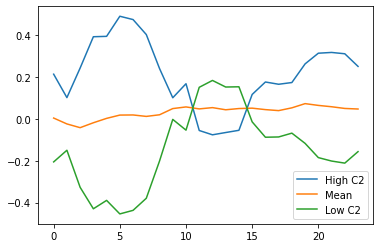

In [33]:
comp3_high_idx, comp3_low_idx = [np.where(manifold_2D_iso['Component 3'] > manifold_2D_iso['Component 3'].median()),
                 np.where(manifold_2D_iso['Component 3'] < manifold_2D_iso['Component 3'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp3_high_idx].mean(axis=0), label='High C2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp3_low_idx].mean(axis=0), label='Low C2')

## LLE

Component 2 - phi

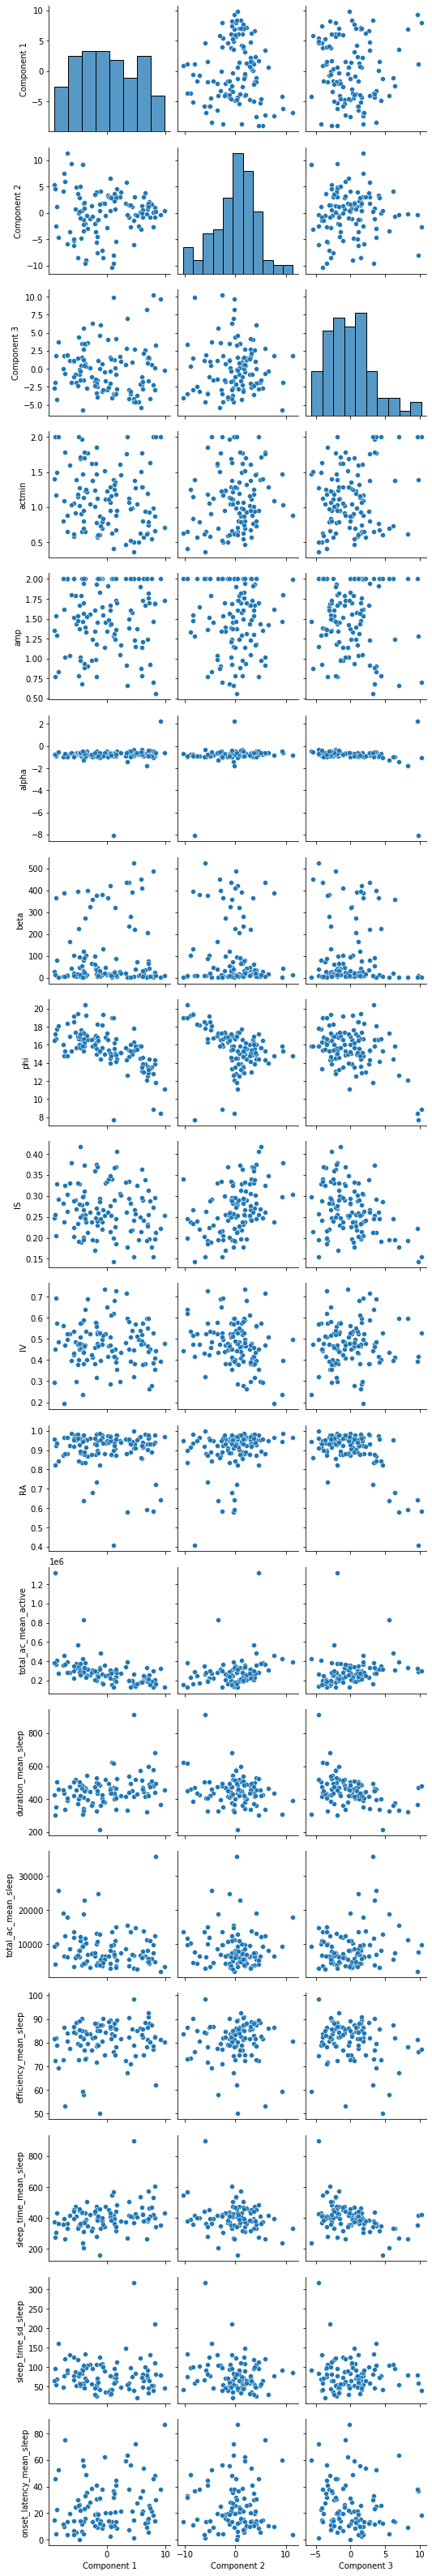

In [34]:
sns.pairplot(data=manifold_2D_lle.join(rar2.reset_index().drop('index', axis=1)), 
             x_vars = [col for col in manifold_2D_lle.columns if col.startswith('Component')])

<AxesSubplot:>

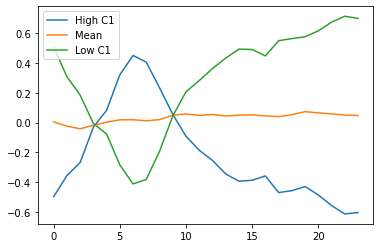

In [35]:
comp1_high_idx, comp1_low_idx = [np.where(manifold_2D_lle['Component 1'] > manifold_2D_lle['Component 1'].median()),
                 np.where(manifold_2D_lle['Component 1'] < manifold_2D_lle['Component 1'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp1_high_idx].mean(axis=0), label='High C1')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp1_low_idx].mean(axis=0), label='Low C1')

<AxesSubplot:>

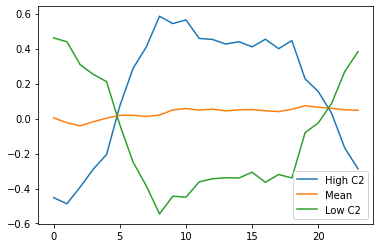

In [36]:
comp2_high_idx, comp2_low_idx = [np.where(manifold_2D_lle['Component 2'] > manifold_2D_lle['Component 2'].median()),
                 np.where(manifold_2D_lle['Component 2'] < manifold_2D_lle['Component 2'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp2_high_idx].mean(axis=0), label='High C2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp2_low_idx].mean(axis=0), label='Low C2')

<AxesSubplot:>

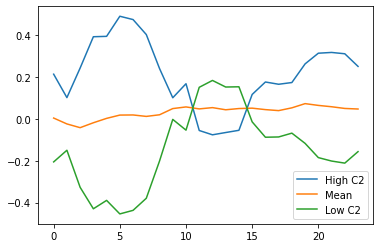

In [37]:
comp3_high_idx, comp3_low_idx = [np.where(manifold_2D_lle['Component 3'] > manifold_2D_lle['Component 3'].median()),
                 np.where(manifold_2D_lle['Component 3'] < manifold_2D_lle['Component 3'].median())]

sns.lineplot(x=range(0,len(x[0])), y=x[comp3_high_idx].mean(axis=0), label='High C2')
sns.lineplot(x=range(0,len(x[0])), y=x.mean(axis=0), label='Mean')
sns.lineplot(x=range(0,len(x[0])), y=x[comp3_low_idx].mean(axis=0), label='Low C2')

## Correlations

MAE: Average absolute error between the model prediction and the actual observed data. <br>
RMSE: Lower the RMSE, the more closely a model is able to predict the actual observations.

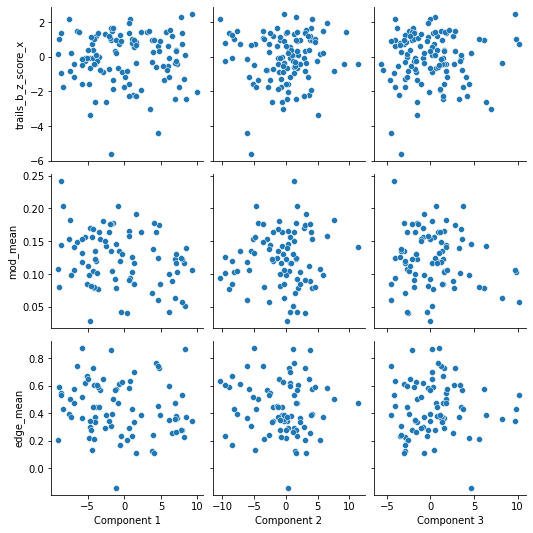

In [38]:
sns.pairplot(data=manifold_2D_iso.join(targets[['trails_b_z_score_x', 'mod_mean', 'edge_mean']].reset_index()), 
             x_vars = [col for col in manifold_2D_iso.columns if col.startswith('Component')],
            y_vars = ['trails_b_z_score_x', 'mod_mean', 'edge_mean'])

In [39]:
#define cross-validation method to use
cv = LeaveOneOut()

#build multiple linear regression model
model = LinearRegression()

#trails b
scores = cross_val_score(model, manifold_2D_iso, targets['trails_b_z_score_x'], 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

print('Trails B, MAE: %.2f, RMSE: %.2f' % (np.mean(np.absolute(scores)), np.sqrt(np.mean(np.absolute(scores)))))


#modularity
scores = cross_val_score(model, manifold_2D_iso, targets['mod_mean'], 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

print('Modularity, MAE: %.2f, RMSE: %.2f' % (np.mean(np.absolute(scores)), np.sqrt(np.mean(np.absolute(scores)))))

      
#edge strength
scores = cross_val_score(model, manifold_2D_iso, targets['edge_mean'], 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)


print('Edge Strength, MAE: %.2f, RMSE: %.2f' % (np.mean(np.absolute(scores)), np.sqrt(np.mean(np.absolute(scores)))))


Trails B, MAE: 1.17, RMSE: 1.08


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "/usr/local/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 880, in check_X_y
    y = check_array(y, accept_sparse='csr', force_all_finite=

File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "/usr/local/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 880, in check_X_y
    y = check_array(y, accept_sparse='csr', force_all_finite=True,
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 720, in check_array
    _assert_all

Modularity, MAE: nan, RMSE: nan


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "/usr/local/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 880, in check_X_y
    y = check_array(y, accept_sparse='csr', force_all_finite=

True,
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 720, in check_array
    _assert_all_finite(array,
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 103, in _assert_all_finite
    raise ValueError(
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  warnings.warn("Estimator fit failed. The score on this train-test"
/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/sit

Edge Strength, MAE: nan, RMSE: nan


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "/usr/local/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 880, in check_X_y
    y = check_array(y, accept_sparse='csr', force_all_finite=

# Classification 

## SVM

[Datacamp](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)

### Cognition

In [40]:
targets.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'age', 'group', 'gender',
       'trails_b_z_score_x', 'trails_b_group', 'duration_mean_active',
       'duration_mean_daily', 'duration_mean_rest',
       ...
       'pc_dmn_fpn_20', 'pc_dmn_fpn_mean', 'pc_dmn_mean', 'pc_fpn_mean',
       'edge_0', 'edge_1', 'edge_2', 'edge_3', 'acc_mean_test_log',
       'edge_mean'],
      dtype='object', length=271)

In [41]:
targets = targets.reset_index()

targets['trails_b_group'] = np.where(targets['trails_b_z_score_x'] > 1, "High", "Average")
targets['trails_b_group'] = np.where(targets['trails_b_z_score_x'] < -1, "Low", targets['trails_b_group'])

average_idx = targets[targets['trails_b_group'] == 'Average'].index.values

In [42]:
print('PCA Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_pca, targets['trails_b_group'], metric='euclidean'))
print('Isomap Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_iso, targets['trails_b_group'], metric='euclidean'))
print('LLE Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_lle, targets['trails_b_group'], metric='euclidean'))

silscore = pd.DataFrame({'method': ['PCA', 'Isomap', 'LLE'],
                        'silscore': [metrics.silhouette_score(manifold_2D_pca, targets['trails_b_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_iso, targets['trails_b_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_lle, targets['trails_b_group'], metric='euclidean')]})


print('\n\n%s' % silscore.min())

PCA Silhouette score: -0.024
Isomap Silhouette score: -0.032
LLE Silhouette score: -0.032


method        Isomap
silscore   -0.031695
dtype: object


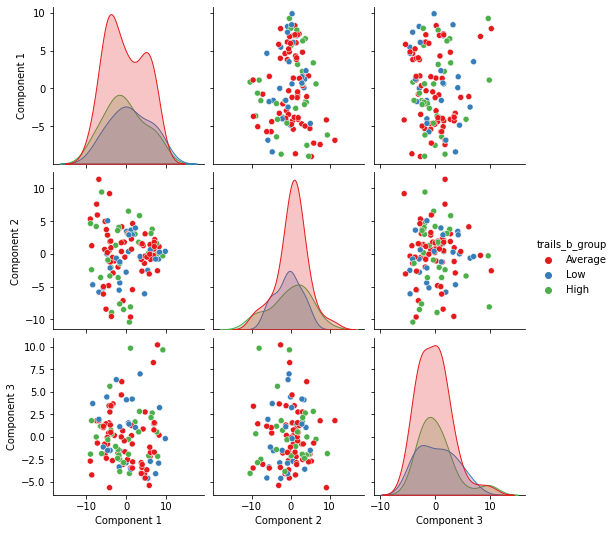

In [43]:
sns.pairplot(manifold_2D_iso.join(targets['trails_b_group'].reset_index()), 
             hue = 'trails_b_group', palette='Set1',
             x_vars = [col for col in manifold_2D_lle.columns if col.startswith('Component')],
             y_vars = [col for col in manifold_2D_lle.columns if col.startswith('Component')])

:::{note}
The Silhouette score measures the separability between clusters based on the distances between and within clusters. It calculates the mean intra-cluster distance (a), which is the mean distance within a cluster, and the mean nearest-cluster distance (b), which is the distance between a sample and the nearest cluster it is not a part of, for each sample. Then, the Silhouette coefficient for a sample is (b - a) / max(a, b). - [Maarten Grootendorst](https://www.maartengrootendorst.com/blog/customer/)
:::

Isomap yields the lowest silhouette score, suggesting that this dimensionality reduction technique as implemented with the selected parameters outperformed PCA and LLE techniques in terms of cluster separability based on Trails B performance ('high', 'average', 'low').

In [44]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(manifold_2D_iso.drop(index=average_idx), 
                                                    targets['trails_b_group'][targets['trails_b_group'] != 'Average'], 
                                                    test_size=0.3, random_state=100) 

print('Training data points: dim_x = %s, dim_y = %s' % (X_train.shape, y_train.shape))
print('Test data points: dim_x = %s, dim_y = %s' % (X_test.shape, y_test.shape))

Training data points: dim_x = (38, 3), dim_y = (38,)
Test data points: dim_x = (17, 3), dim_y = (17,)


In [45]:
#Create a svm Classifier
kernel_methods = ['linear', 'poly', 'rbf', 'sigmoid']
accdf = pd.DataFrame()

for kernel_method in kernel_methods:
    
    clf = svm.SVC(kernel=kernel_method)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    accdf = accdf.append({'method': kernel_method,
                      'accuracy': acc}, ignore_index=True)
    

    print(kernel_method + ", Accuracy: %.2f " % acc)
    

print('\n\n%s' % accdf.max())

linear, Accuracy: 0.41 
poly, Accuracy: 0.47 
rbf, Accuracy: 0.53 
sigmoid, Accuracy: 0.59 


method       sigmoid
accuracy    0.588235
dtype: object


In [46]:
clf = svm.SVC(kernel=accdf.max()['method'])

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [47]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision: %.2f" % metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall: %.2f" % metrics.recall_score(y_test, y_pred, average='weighted'))

Precision: 0.62
Recall: 0.59


In [48]:
markers = y_pred + ', ' + y_test

px.scatter_3d(x=X_test['Component 1'], 
              y=X_test['Component 2'], 
              z=targets.iloc[y_test.index.values]['trails_b_z_score_x'],
              color=markers,
              labels = {
                  'x' : 'Component 1',
                  'y' : 'Component 2',
                  'z' : 'Trails B Z-Score',
                  'color': 'Predicted vs. True Performance'
              },
              title='Components and Trails B Z-Score')


### Brain

In [49]:
targets['mod_mean'].fillna(targets['mod_mean'].mean(), inplace=True)
print(targets['mod_mean'])
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
targets['mod_mean_scaled'] = scaler.fit_transform(targets['mod_mean'].values.reshape(-1,1))
targets['mod_mean_scaled'] 

targets['mod_mean_group'] = np.where(targets['mod_mean_scaled'] > 1, "High", "Average")
targets['mod_mean_group'] = np.where(targets['mod_mean_scaled'] < -1, "Low", targets['mod_mean_group'] )

average_idx = targets[targets['mod_mean_group'] == 'Average'].index.values


0      0.204444
1      0.180552
2      0.182655
3      0.123560
4      0.165057
         ...   
111    0.178232
112    0.123560
113    0.139451
114    0.123560
115    0.123560
Name: mod_mean, Length: 116, dtype: float64


In [50]:
print('PCA Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_pca, targets['mod_mean_group'], metric='euclidean'))
print('Isomap Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_iso, targets['mod_mean_group'], metric='euclidean'))
print('LLE Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_lle, targets['mod_mean_group'], metric='euclidean'))

silscore = pd.DataFrame({'method': ['PCA', 'Isomap', 'LLE'],
                        'silscore': [metrics.silhouette_score(manifold_2D_pca, targets['mod_mean_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_iso, targets['mod_mean_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_lle, targets['mod_mean_group'], metric='euclidean')]})


print('\n\n%s' % silscore.min())

PCA Silhouette score: -0.072
Isomap Silhouette score: -0.082
LLE Silhouette score: -0.082


method        Isomap
silscore   -0.082153
dtype: object


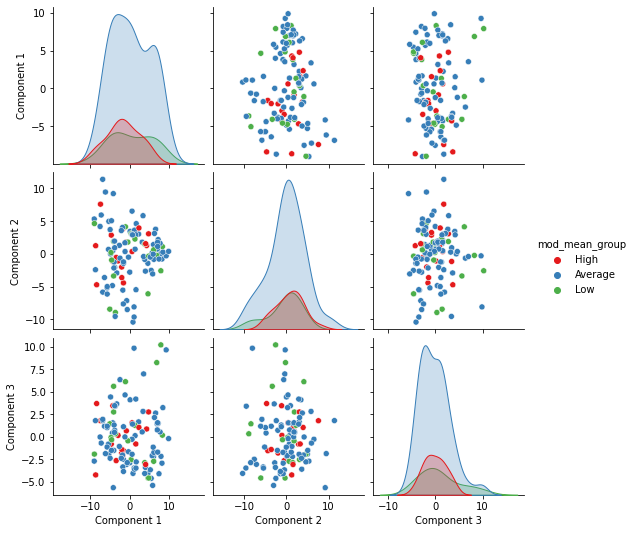

In [51]:
sns.pairplot(manifold_2D_iso.join(targets['mod_mean_group'].reset_index()), 
             hue = 'mod_mean_group', palette='Set1',
             x_vars = [col for col in manifold_2D_iso.columns if col.startswith('Component')],
             y_vars = [col for col in manifold_2D_iso.columns if col.startswith('Component')])

In [52]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(manifold_2D_iso.drop(index=average_idx),
                                                    targets['mod_mean_group'][targets['mod_mean_group'] != 'Average'], 
                                                    test_size=0.3, random_state=100) 

print('Training data points: dim_x = %s, dim_y = %s' % (X_train.shape, y_train.shape))
print('Test data points: dim_x = %s, dim_y = %s' % (X_test.shape, y_test.shape))

Training data points: dim_x = (25, 3), dim_y = (25,)
Test data points: dim_x = (11, 3), dim_y = (11,)


In [53]:
targets['mod_mean_group'].unique()

array(['High', 'Average', 'Low'], dtype=object)

In [54]:
#Create a svm Classifier
kernel_methods = ['linear', 'poly', 'rbf', 'sigmoid']
accdf = pd.DataFrame()

for kernel_method in kernel_methods:
    
    clf = svm.SVC(kernel=kernel_method)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    accdf = accdf.append({'method': kernel_method,
                      'accuracy': acc}, ignore_index=True)
    

    print(kernel_method + ", Accuracy: %.2f " % acc)
    

print('\n\n%s' % accdf.max())

linear, Accuracy: 0.45 
poly, Accuracy: 0.64 
rbf, Accuracy: 0.55 
sigmoid, Accuracy: 0.36 


method       sigmoid
accuracy    0.636364
dtype: object


In [55]:
#Create a svm Classifier
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
clf = svm.SVC(kernel=accdf.max()['method'])

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [56]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision: %.2f" % metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall: %.2f" % metrics.recall_score(y_test, y_pred, average='weighted'))

Precision: 0.37
Recall: 0.36


In [57]:
markers = y_pred + ', ' + y_test

px.scatter_3d(x=X_test['Component 1'], 
              y=X_test['Component 2'], 
              z=targets.iloc[y_test.index.values]['mod_mean_group'],
              color=markers,
              labels = {
                  'x' : 'Component 1',
                  'y' : 'Component 2',
                  'z' : 'DMN-FPN Modularity',
                  'color': 'Predicted vs. Truth'
              },
              title='Components and DMN-FPN Modularity')



In [58]:
targets['edge_mean'].fillna(targets['edge_mean'].mean(), inplace=True)
print(targets['edge_mean'])
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
targets['edge_mean_scaled'] = scaler.fit_transform(targets['edge_mean'].values.reshape(-1,1))
targets['edge_mean_scaled'] 

targets['edge_mean_group'] = np.where(targets['edge_mean_scaled'] > 1, "High", "Average")
targets['edge_mean_group'] = np.where(targets['edge_mean_scaled'] < -1, "Low", targets['edge_mean_group'] )

average_idx = targets[targets['edge_mean_group'] == 'Average'].index.values

0      0.476839
1      0.648607
2      0.500161
3      0.438322
4      0.295476
         ...   
111    0.112614
112    0.438322
113    0.373898
114    0.438322
115    0.438322
Name: edge_mean, Length: 116, dtype: float64


In [59]:
print('PCA Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_pca, targets['edge_mean_group'], metric='euclidean'))
print('Isomap Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_iso, targets['edge_mean_group'], metric='euclidean'))
print('LLE Silhouette score: %.3f' % metrics.silhouette_score(manifold_2D_lle, targets['edge_mean_group'], metric='euclidean'))

silscore = pd.DataFrame({'method': ['PCA', 'Isomap', 'LLE'],
                        'silscore': [metrics.silhouette_score(manifold_2D_pca, targets['edge_mean_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_iso, targets['edge_mean_group'], metric='euclidean'),
                                    metrics.silhouette_score(manifold_2D_lle, targets['edge_mean_group'], metric='euclidean')]})


print('\n\n%s' % silscore.min())

PCA Silhouette score: -0.088


Isomap Silhouette score: -0.070
LLE Silhouette score: -0.070


method        Isomap
silscore   -0.087929
dtype: object


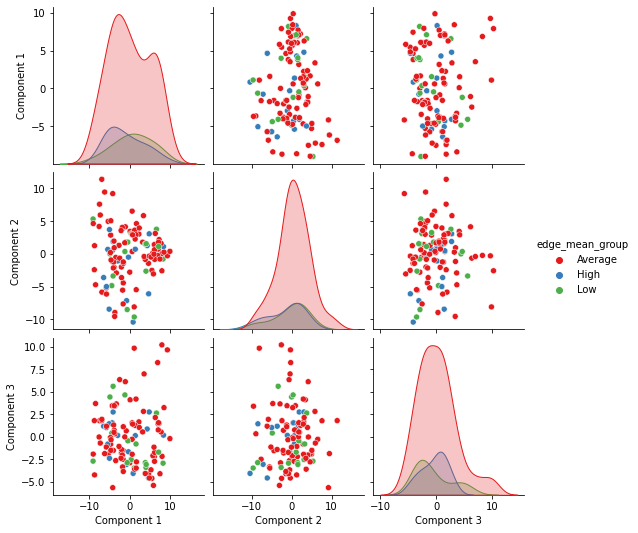

In [60]:
sns.pairplot(manifold_2D_iso.join(targets['edge_mean_group'].reset_index()), 
             hue = 'edge_mean_group', palette='Set1',
             x_vars = [col for col in manifold_2D_iso.columns if col.startswith('Component')],
             y_vars = [col for col in manifold_2D_iso.columns if col.startswith('Component')])

In [61]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(manifold_2D_iso.drop(index=average_idx),
                                                    targets['edge_mean_group'][targets['edge_mean_group'] != 'Average'], 
                                                    test_size=0.3, random_state=100) 

print('Training data points: dim_x = %s, dim_y = %s' % (X_train.shape, y_train.shape))
print('Test data points: dim_x = %s, dim_y = %s' % (X_test.shape, y_test.shape))

Training data points: dim_x = (23, 3), dim_y = (23,)
Test data points: dim_x = (10, 3), dim_y = (10,)


In [62]:
targets['edge_mean_group'].unique()

array(['Average', 'High', 'Low'], dtype=object)

In [63]:
#Create a svm Classifier
kernel_methods = ['linear', 'poly', 'rbf', 'sigmoid']
accdf = pd.DataFrame()

for kernel_method in kernel_methods:
    
    clf = svm.SVC(kernel=kernel_method)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    accdf = accdf.append({'method': kernel_method,
                      'accuracy': acc}, ignore_index=True)
    

    print(kernel_method + ", Accuracy: %.2f " % acc)
    

print('\n\n%s' % accdf.max())

linear, Accuracy: 0.40 
poly, Accuracy: 0.50 
rbf, Accuracy: 0.50 
sigmoid, Accuracy: 0.40 


method      sigmoid
accuracy        0.5
dtype: object


In [64]:
#Create a svm Classifier
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
clf = svm.SVC(kernel=accdf.max()['method'])

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [65]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision: %.2f" % metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall: %.2f" % metrics.recall_score(y_test, y_pred, average='weighted'))

Precision: 0.45
Recall: 0.40


In [66]:
markers = y_pred + ', ' + y_test

px.scatter_3d(x=X_test['Component 1'], 
              y=X_test['Component 2'], 
              z=targets.iloc[y_test.index.values]['edge_mean_group'],
              color=markers,
              labels = {
                  'x' : 'Component 1',
                  'y' : 'Component 2',
                  'z' : 'Memory Network Edge Strength',
                  'color': 'Predicted vs. Truth'
              },
              title='Components and Memory Network Edge Strength')
